In [1]:
import numpy as np
import pandas as pd
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
import numpy as np
import plotly.offline as of
import plotly.graph_objs as go
from show_img import show_img
from model import my_model
from plot_conf import plot_conf
of.offline.init_notebook_mode(connected=True)
import h5py
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## Show 3D image 

In [3]:
show_img()

## Image processing

In [4]:
for dirname,_, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname,filename))

with h5py.File('archive/full_dataset_vectors.h5', 'r') as dataset:
    x_train = dataset["X_train"][:]
    x_test = dataset["X_test"][:]
    y_train = dataset["y_train"][:]
    y_test = dataset["y_test"][:]

print ("x_train shape: ", x_train.shape)
print ("y_train shape: ", y_train.shape)
print ("x_test shape:  ", x_test.shape)
print ("y_test shape:  ", y_test.shape)

xtrain = np.ndarray((x_train.shape[0], 4096, 3))
xtest = np.ndarray((x_test.shape[0], 4096, 3))

def add_rgb_dimention(array):
    scaler_map = cm.ScalarMappable(cmap="Oranges")
    array = scaler_map.to_rgba(array)[:, : -1]
    return array

for i in range(x_train.shape[0]):
    xtrain[i] = add_rgb_dimention(x_train[i])
for i in range(x_test.shape[0]):
    xtest[i] = add_rgb_dimention(x_test[i])


xtrain = xtrain.reshape(x_train.shape[0], 16, 16, 16, 3)
xtest = xtest.reshape(x_test.shape[0], 16, 16, 16, 3)

print(xtrain.shape)

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

x_train shape:  (10000, 4096)
y_train shape:  (10000,)
x_test shape:   (2000, 4096)
y_test shape:   (2000,)
(10000, 16, 16, 16, 3)


## Initial Model and setting hyperparameter

## Training and save model

In [5]:
checkpoint_path = "training/cp-1.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
    verbose=1, save_weights_only=True)

model = my_model()
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc'])
model.build(input_shape=(None, 16,16,16,3))
# model.summary()


model.fit(x=xtrain, y=y_train, batch_size=128, epochs=5, validation_split=0.2,callbacks=[cp_callback])



Epoch 1/5
63/63 [==============================] - ETA: 0s - loss: 1.6726 - acc: 0.4283
Epoch 00001: saving model to training/cp-1.ckpt
63/63 [==============================] - 38s 596ms/step - loss: 1.6726 - acc: 0.4283 - val_loss: 1.3027 - val_acc: 0.5525
Epoch 2/5
63/63 [==============================] - ETA: 0s - loss: 1.1168 - acc: 0.6161
Epoch 00002: saving model to training/cp-1.ckpt


In [ ]:
model.load_weights(checkpoint_path)
model.evaluate(x=xtest,y=y_test)
predictions = model.predict(xtest)
pred_class = tf.math.argmax(predictions,1)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

## Plot confusion matrix 

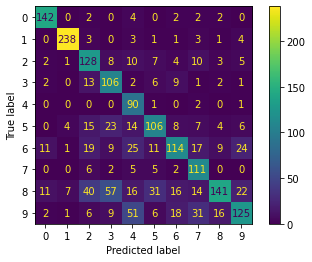

In [ ]:
plot_conf(pred_class, y_test)